# ODE for generative modeling

The notebook implements generative modeling with an ordinary differential equation (ODE) for a latent variable $x_t$, $t\in [0,1]$ using the following three steps:
\begin{align*}
x_0 & \sim p(x_0) \\
dx & = f(x,t)\, dt, \hspace{15mm}  t \in [0,1] \\
y & = x_1
\end{align*}
In the notebook we will simulate data from a known one dimensional distribution. We will use a generated training set to learn the ODE drift function $f(x,t)$ parameterized as a neural network.

We can compute the likelihood $p(y)$ exactly for this setup and this is done in the code.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import laplace
from torchsummary import summary

## GPU

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Data generation class

In [4]:
import torch
import numpy as np

class TrainingSetWithLogLikelihood:
    def __init__(self, distribution, params):
        self.distribution = distribution
        self.params = params

    def generate_training_data(self, n_samples=5000):
        """
        Generate a training dataset and compute the true expected log likelihood for this data.
        :return: training_data (tensor), expected_log_likelihood (float)
        """
        if self.distribution == 'laplace_mixture':
            k = self.params['k']  # Number of components
            spacing = self.params['spacing']  # spacing between means
            scale = self.params['scale']  # Laplace scale (spread)
            means = np.arange(-spacing * (k - 1) / 2, spacing * ( (k - 1) / 2 + 1), spacing)

            data = self.generate_laplace_mixture(n_samples, means, scale)

            # Compute the log likelihood for the Laplace mixture distribution
            expected_log_likelihood = self.laplace_mixture_log_likelihood(data, means, scale)

        elif self.distribution == 'laplace':
            loc, scale = self.params['loc'], self.params['scale']
            data = torch.tensor(np.random.laplace(loc=loc, scale=scale, size=(n_samples, 1)), dtype=torch.float32)

            # Compute the log likelihood for the Laplace distribution
            expected_log_likelihood = self.laplace_log_likelihood(data, loc, scale)

        elif self.distribution == 'gaussian':
            mean, std = self.params['mean'], self.params['std']
            data = torch.tensor(np.random.normal(loc=mean, scale=std, size=(n_samples, 1)), dtype=torch.float32)

            # Compute the log likelihood for the Gaussian distribution
            expected_log_likelihood = self.gaussian_log_likelihood(data, mean, std)

        else:
            raise ValueError(f"Unsupported distribution: {self.distribution}")

        return data, expected_log_likelihood

    def generate_laplace_mixture(self, n_samples, means, scale):
        """
        Generate data from a mixture of Laplace distributions.
        :param n_samples: Number of samples to generate
        :param k: Number of components (each side of 0)
        :param scale: Scale parameter for the Laplace distribution
        :return: Generated data (tensor)
        """
        n_components = len(means)
        proportions = np.ones(n_components) / n_components  # Uniform mixture
        data = []

        for _ in range(n_samples):
            mean = np.random.choice(means, p=proportions)  # Select a component
            sample = np.random.laplace(loc=mean, scale=scale)  # Generate a sample
            data.append(sample)

        return torch.tensor(data, dtype=torch.float32).unsqueeze(1)

    def laplace_mixture_log_likelihood(self, data, means, scale):
        """
        Compute the log likelihood for a mixture of Laplace distributions.
        :param data: Training data tensor
        :param means: Means of the Laplace components
        :param scale: Scale parameter of the Laplace components
        :return: Expected log likelihood (float)
        """
        log_likelihoods = []
        for mean in means:
            log_likelihood = -torch.abs(data - mean) / scale - torch.log(2 * scale)
            log_likelihoods.append(log_likelihood)

        # Convert to a tensor and compute the log of the sum across components
        log_likelihoods = torch.stack(log_likelihoods, dim=1)  # Shape: (n_samples, n_components)
        mixture_log_likelihood = torch.logsumexp(log_likelihoods, dim=1) - np.log(len(means))

        return mixture_log_likelihood.mean().item()

    def laplace_log_likelihood(self, data, loc, scale):
        """
        Compute the log likelihood for the Laplace distribution.
        :param data: Training data tensor
        :param loc: Location (mean) parameter of the Laplace distribution
        :param scale: Scale parameter of the Laplace distribution
        :return: Expected log likelihood (float)
        """
        log_likelihood = -torch.abs(data - loc) / scale - torch.log(2 * scale)
        return log_likelihood.mean().item()

    def gaussian_log_likelihood(self, data, mean, std):
        """
        Compute the log likelihood for the Gaussian distribution.
        :param data: Training data tensor
        :param mean: Mean of the Gaussian distribution
        :param std: Standard deviation of the Gaussian distribution
        :return: Expected log likelihood (float)
        """
        log_likelihood = -0.5 * ((data - mean)**2 / std**2) - 0.5 * torch.log(2 * torch.pi * std**2)
        return log_likelihood.mean().item()


## Prior distribution

In [5]:
# Unified prior interface for both distribution and log probability
class Prior:
    def __init__(self, sample_func, log_prob_func):
        self.sample_func = sample_func
        self.log_prob_func = log_prob_func

    def sample(self, n_samples):
        return self.sample_func(n_samples)

    def log_prob(self, x):
        return self.log_prob_func(x)

# Gaussian prior distribution
def gaussian_sample(n_samples):
    return torch.tensor(np.random.normal(loc=0, scale=1, size=(n_samples, 1)), dtype=torch.float32)

# Laplace prior distribution
def laplace_sample(n_samples):
    return torch.tensor(np.random.laplace(loc=0, scale=1, size=(n_samples, 1)), dtype=torch.float32)

# Gaussian log probability for prior (mean=0, variance=1)
def gaussian_log_pdf(x):
    return -0.5 * torch.log(torch.tensor(2 * np.pi)) - 0.5 * x**2

# Laplace log probability for prior (mean=0, scale=1)
def laplace_log_pdf(x):
    return -torch.abs(x) - torch.log(torch.tensor(2.0))

## Drift function

In [6]:
# Define the drift network f(x, t)
class DriftNetwork(nn.Module):
    def __init__(self):
        super(DriftNetwork, self).__init__()
        self.net = nn.Sequential(
            #nn.Linear(2,1),
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    #def forward(self, x, t):
        #t = t.expand_as(x)
        #x_t = torch.cat([x, t], dim=-1)
        #return self.net(x_t)
    def forward(self, x, t):
      if t.dim() == 1:
        t = t.unsqueeze(1).expand_as(x[:, :1])

      x_t = torch.cat([x, t], dim=-1)
      return self.net(x_t)


## Forward and backward path generation and visualization

In [7]:
import torch

class ForwardPath:
    def __init__(self, mode="ode", f_net=None, sigma_net=None, prior=None, likelihood_func=None):
        """
        Initialize the ForwardPath object to solve the forward path from t=0 to t=1.

        :param mode: Mode to select ("ode" or "sde")
        :param f_net: Neural network defining the ODE drift or SDE drift
        :param sigma_net: Neural network defining the diffusion term (used in SDE)
        :param prior: Prior distribution object with a `sample` method for t=0 sampling
        :param likelihood_func: Likelihood function object y ~ p(y|x_1). If None the continuous flow formulation is used with y = x_1.
        """
        assert mode in ["ode", "sde"], "Invalid mode selected."
        self.mode = mode
        self.f_net = f_net
        self.sigma_net = sigma_net
        self.prior = prior
        self.likelihood_func = likelihood_func

    def sample_prior(self, n_samples):
        """Sample from the prior distribution at t=0."""
        return self.prior.sample(n_samples)

    def integrate(self, x0, t_grid):
        """
        Integrate the forward path from t=0 to t=1 based on the chosen mode.

        :param x0: Initial samples from the prior distribution at t=0
        :param t_grid: Time grid for integration
        :return: Path of samples from t=0 to t=1

        Note: So far only implemented for Euler-Maruyama integration
        """
        x_t = x0
        paths = [x0]

        # Calculate dt based on t_grid spacing
        dt = t_grid[1] - t_grid[0]

        for t in t_grid[:-1]:  # Integrate from t=0 to t=1

            t = t.expand_as(x_t)

            if self.mode == "ode":
                drift = self.f_net(x_t, t) #torch.tensor([t]))
                x_t = x_t + drift * dt

            elif self.mode == "sde":
                drift = self.f_net(x_t, t) #torch.tensor([t]))
                sigma = self.sigma_net(x_t, t) #torch.tensor([t]))
                noise = torch.randn_like(x_t) * torch.sqrt(dt)
                x_t = x_t + drift * dt + sigma * noise

            paths.append(x_t)

        return torch.stack(paths)

    def sample_data(self, x_1):
        """
        Sample data based on the final x_1 in one of two ways:
        :param x_1: The final samples at t=1
        :param use_likelihood: If True, sample from p(y|x_1) using the likelihood function. If False, set y=x_1.
        :return: Samples y based on the final distribution

        Note: So far only implemented for Euler-Maruyama integration
       """
        if self.likelihood_func is not None:
            return self.likelihood_func.sample(x_1)  # Sample y ~ p(y | x_1)
        else:
            return x_1  # Continuous flow case where y = x_1

    def sample(self, n_samples, t_grid):

        # Sample initial points from the prior
        x0 = self.sample_prior(n_samples)

        # Integrate the forward path
        path = self.integrate(x0, t_grid)

        # Sample data y using the likelihood function
        y = self.sample_data(path[-1])

        return y, path, x0

class BackwardPath:
    def __init__(self, mode="ode", start="direct", f_net=None, alpha_net=None, beta_net=None, sigma_net=None, likelihood_func=None):
        """
        Initialize the BackwardPath object to solve the path from t=1 to t=0.
        Uses either ODE model ("f_net") or variational distribution ("ode" and "backward sde").

        :param mode: Mode to select ("f_net", "ode", "backward sde").
        :param f_net: Neural network defining the drift for straight ODE in "f_net" mode
        :param alpha_et: Neural network defining the mean for variational in "ode" and "backward sde" mode
        :param beta_net: Neural network defining the standard deviation for variational in "ode" and "backward_sde" mode
        :param sigma_net: Neural network defining the diffusion term (used in SDE cases) in "backward sde" mode
        :param likelihood_func: Likelihood function object. If not None then x1 ~ q_1(x_1|y)) else the continuous flow formulation is used x1 = y.
        """
        assert mode in ["f_net", "ode", "backward sde"], "Invalid mode selected."
        self.mode = mode
        self.f_net = f_net
        self.alpha_net = alpha_net
        self.beta_net = beta_net
        self.sigma_net = sigma_net
        self.likelihood_func = likelihood_func

    def sample_starting_point(self, y):
        """Define x1 either as y or by sampling from q_1(x_1|y)."""
        if self.likelihood_func is None:
            return y
        else: # use variational
            q_x1_given_y = Variational(self.alpha_net, self.beta_net, y, torch.full(y.size(), 1.0))
            return q_x1_given_y.sample()

    def integrate(self, x1, t_grid, y=None):
        """
        Integrate the backward path from t=1 to t=0 based on the chosen mode.

        :param x1: Starting samples at t=1 (either y directly or sampled from q(x,1|y))
        :param t_grid: Time grid for integration
        :param y: Observed data for calculating score term when using q(x,t|y)
        :return: Path of samples from t=1 to t=0
        """
        x_t = x1
        paths = [x1]

        # Calculate dt based on t_grid spacing and reverse for backward integration
        dt = -(t_grid[1] - t_grid[0])

        for t in reversed(t_grid[1:]):  # Integrate backward from t=1 to t=0

            t = t.expand_as(x_t)

            # Compute the drift based on the specified mode
            if self.mode == "ode":
                drift = self.f_net(x_t, t)
            else: # use variational
                t.requires_grad = True # drift calculation requires
                q_xt_given_y = Variational(self.alpha_net, self.beta_net, y, t)
                drift, _ = q_xt_given_y.drift(x_t, mode=self.mode, sigma_net=self.sigma_net)

            x_t = x_t + drift * dt

            if self.mode == "backward sde":
                dW = torch.randn_like(x_t) * torch.sqrt(-dt)  # Simulate Brownian motion increment
                x_t = x_t + self.sigma_net(x_t, t) * dW

            paths.append(x_t)

        # Reverse the paths to go from t=0 to t=1
        return torch.stack(paths[::-1])

    def sample(self, y, t_grid):

      # Sample starting points from data y
      x1 = self.sample_starting_point(y)

      # Integrate the backward path
      path = self.integrate(x1, t_grid, y=y)

      # Extract prior samples x0
      x0 = path[0]

      return x0, path, x1

def visualize_paths_and_marginals(data, t_grid, backward_path, forward_path):
    fig = plt.figure(figsize=(12, 8))

    # 3D plot
    ax = fig.add_subplot(111, projection='3d')

    # Define the x-range
    x_range = (-10, 10)

    # Plot the training data density at t=1 as a histogram
    hist_vals, bin_edges = np.histogram(data.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.plot(np.ones_like(bin_centers), bin_centers, hist_vals, color='b', lw=2, label="Training Data (t=1)")

    # number of samples
    n_samples = data.shape[0]

    # get backward paths
    x0_backward, backward_paths, x1 = backward_path.sample(data, t_grid)

    # Plot the backward paths (from x(1) to x(0)) - max 10
    for i in range(min(10,n_samples)):
        ax.plot(t_grid, backward_paths[:, i].detach().numpy().squeeze(), np.zeros_like(t_grid), lw=1, color='r', alpha=0.7, label="Backward Paths (dt<0)" if i == 0 else "")

    # get forward paths
    y_samples, forward_paths, x0 = forward_path.sample(n_samples, t_grid)

    # Plot the forward paths (from x(0) to x(1)) - max 10
    for i in range(min(10,n_samples)):
        ax.plot(t_grid, forward_paths[:, i].detach().numpy().squeeze(), np.zeros_like(t_grid), lw=1, color='purple', alpha=0.7, label="Forward Paths (dt>0)" if i == 0 else "")

    # Plot the generated data density
    hist_vals_endpoints, bin_edges_endpoints = np.histogram(y_samples.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_endpoints = 0.5 * (bin_edges_endpoints[1:] + bin_edges_endpoints[:-1])
    ax.plot(np.ones_like(bin_centers_endpoints), bin_centers_endpoints, hist_vals_endpoints, color='orange', lw=2, label="Generated Data (t=1)")
    #hist_vals_endpoints, bin_edges_endpoints = np.histogram(generated_paths_endpoints.detach().numpy(), bins=50, range=x_range, density=True)
    #bin_centers_endpoints = 0.5 * (bin_edges_endpoints[1:] + bin_edges_endpoints[:-1])
    #ax.plot(np.ones_like(bin_centers_endpoints), bin_centers_endpoints, hist_vals_endpoints, color='orange', lw=2, label="Generated Latent (t=1)")

    # Plot the prior density (t=0) for the training data solved backward
    #training_prior = backward_paths[0, :].detach().numpy()  # Paths solved back to t=0
    hist_vals_prior, bin_edges_prior = np.histogram(x0_backward.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_prior = 0.5 * (bin_edges_prior[1:] + bin_edges_prior[:-1])
    ax.plot(np.zeros_like(bin_centers_prior), bin_centers_prior, hist_vals_prior, color='b', lw=2, linestyle='--', label="Training Data Latent (t=0)")

    # Plot the prior density (t=0) for samples drawn from the prior
    #prior_samples = forward_paths[0, :]  # Take the initial point at t=0
    hist_vals_prior_samples, bin_edges_prior_samples = np.histogram(x0.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_prior_samples = 0.5 * (bin_edges_prior_samples[1:] + bin_edges_prior_samples[:-1])
    ax.plot(np.zeros_like(bin_centers_prior_samples), bin_centers_prior_samples, hist_vals_prior_samples, color='orange', lw=2, linestyle='--', label="Prior Samples (t=0)")

    # Set the y-axis limits
    plt.ylim(-10, 10)

    # Labels
    ax.set_xlabel('Time')
    ax.set_ylabel('x(t)')
    ax.set_zlabel('Density')
    ax.set_title('Comparison of Prior Densities, Training Data, and Generated Paths')
    ax.legend()

    plt.show()

## ODE simulation, log likelihood and training loop

In [8]:
# Define the partial derivative of the drift function with respect to x(t)
def partial_drift_x(ode_func, x, t):
    x.requires_grad_(True)
    drift = ode_func(x, t)
    partial_derivative = torch.autograd.grad(outputs=drift, inputs=x, grad_outputs=torch.ones_like(drift), create_graph=True)[0]
    return partial_derivative

# Simulate the ODE generalized for both forward and backward (reverse)
def simulate_ode(ode_func, x_start, t, method="euler", reverse=False):
    """
    Simulate the coupled ODE system for state and log-probability equations using the specified method.
    The state and log-probability are treated as a concatenated vector.

    :param ode_func: Neural network parameterizing the drift.
    :param x_start: Starting value (x(0) for forward, x(1) for backward).
    :param t: Time points for integration.
    :param method: Integration method ("euler", "rk2", "rk4").
    :param reverse: Whether to integrate backward in time.
    :return: Simulated paths for state and log-likelihood.
    """
    x = x_start
    log_likelihood = torch.zeros(x.size(0))  # Initialize the log-likelihood term
    state = torch.cat([x, log_likelihood.unsqueeze(1)], dim=1)  # Concatenate state and log-probability
    paths = [x_start]
    dt = t[1] - t[0]
    dt = -dt if reverse else dt

    def concatenated_integrands(state, t):
        """
        Compute the derivatives for both the state and log-probability equations.
        :param state: Concatenated vector [x, log_p].
        :param t: Current time.
        :return: Derivative of the concatenated state.
        """
        x = state[:, :-1]  # Extract state x
        log_p = state[:, -1:]  # Extract log-probability (unused in computation)

        # Compute drift and partial derivative in one pass
        x.requires_grad_()
        t = t.expand_as(x)
        drift = ode_func(x, t)
        partial_derivative = torch.autograd.grad(
            outputs=drift,
            inputs=x,
            grad_outputs=torch.ones_like(drift),
            create_graph=True
        )[0]

        # Derivative for state
        dx_dt = drift

        # Derivative for log-probability
        dlogp_dt = -partial_derivative

        # Concatenate the derivatives
        return torch.cat([dx_dt, dlogp_dt], dim=1)

    def integrate_step(method, func, state, t, dt):
        if method == "euler":
            derivative = func(state, t)
            return state + derivative * dt

        elif method == "rk2": # midpoint method
            k1 = func(state, t)
            mid_state = state + 0.5 * dt * k1
            t_mid = t + 0.5 * dt
            k2 = func(mid_state, t_mid)
            return state + dt * k2

        elif method == "rk4":
            k1 = func(state, t)
            mid_state_1 = state + 0.5 * dt * k1
            t_mid = t + 0.5 * dt
            k2 = func(mid_state_1, t_mid)
            mid_state_2 = state + 0.5 * dt * k2
            k3 = func(mid_state_2, t_mid)
            end_state = state + dt * k3
            t_end = t + dt
            k4 = func(end_state, t_end)
            return state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        else:
            raise ValueError(f"Unknown integration method: {method}")

    # Reverse time grid if needed
    time_points = reversed(t[:-1]) if reverse else t[:-1]

    for t_i in time_points:
        t_i = t_i.expand_as(x)

        # Integrate the concatenated state
        state = integrate_step(method, concatenated_integrands, state, t_i, dt)

        # Separate the updated state and log-probability
        x = state[:, :-1]
        log_likelihood = state[:, -1]

        # Store the state path
        paths.append(x)

    if reverse:
        paths.reverse()
        log_likelihood = -log_likelihood # to correct for dt<0.

    return torch.stack(paths), log_likelihood


def compute_log_likelihood_ode(ode_func, prior, training_data, t, method="euler"):
    """
    Compute the log-likelihood of the training data under the provided prior."
    :param ode_func: Neural network for drift f(x, t)
    :param prior: Prior distribution object (for sampling and log-prob)
    :param training_data: The entire dataset (tensor)
    :param t: Time points for integration
    :param method: Integration method ("euler", "rk2", "rk4")
    :return: Log-likelihood
    """

    # Initialize latent variable in training data
    x1 = training_data

    # Simulate ODE backwards from x1 = training data and calculate log p(x1) term
    paths, log_likelihood_term = simulate_ode(ode_func, x1, t, method=method, reverse=True)
    x0 = paths[0]

    # Log probability under the provided prior
    prior_log_prob = prior.log_prob(x0).squeeze()

    # Total log-likelihood: Exact log p(y=x1) = log p_0(x0) - integral
    log_likelihood = prior_log_prob + log_likelihood_term

    return log_likelihood.mean()

def training_loop_ode(f_net, prior, data_loader, validation_data, t, method="euler", n_epochs=1000, lr=1e-3):
    """
    Training loop for the ODE model using the exact approach.
    :param f_net: Neural network for drift f(x, t)
    :param prior: Prior distribution object (for sampling and log-prob)
    :param likelihood: Likelihood distribution object (for computing log-likelihood)
    :param data_loader: DataLoader providing the training data
    :param validation_data: the validation data
    :param t: Time points for integration
    :param n_epochs: Number of training epochs
    :param lr: Learning rate for the optimizer
    :return: Trained models
    """
    # Define the optimizer for all the parameters
    optimizer = optim.Adam(
        list(f_net.parameters()),
        lr=lr, weight_decay=0.0
    )

    #backward_path = BackwardPath(mode="ode", f_net=f_net)
    #forward_path = ForwardPath(mode="ode", f_net=f_net, prior=prior)

    # Training loop
    for epoch in range(n_epochs):
        total_loglike = 0.0

        for y_batch in data_loader:
            optimizer.zero_grad()

            loglike = compute_log_likelihood_ode(f_net, prior, y_batch, t, method=method)

            # Accumulate ELBO
            total_loglike += loglike.item()

            # Minimize the negative ELBO
            loss = -loglike
            loss.backward()
            optimizer.step()

        # Print the loss every 100 epochs
        if epoch % 1 == 0 or epoch==n_epochs-1:
            loglike_val = compute_log_likelihood_ode(f_net, prior, validation_data, t, method=method)
            loglike_val_rk4 = compute_log_likelihood_ode(f_net, prior, validation_data, t, method="rk4")
            print(f'Epoch {epoch}, Log Likelihood: {total_loglike / len(data_loader):.5f} (train), {loglike_val:.5f} (val), {loglike_val_rk4:.5f} (val rk4), {loglike_val-loglike_val_rk4:.5f} (val-val rk4)')

    return f_net

## Create training and validation data

In [9]:
## Generate synthetic training data
n_samples = 1000
n_samples_validation = 1000
set_seed(42)
training_set_dist = 'laplace_mixture' #'gaussian' # 'laplace', 'laplace_mixture'

if training_set_dist == 'gaussian':
    params = {'mean': torch.tensor(-1.0), 'std': torch.tensor(2.0)} # Gaussian parameters
    training_set = TrainingSetWithLogLikelihood('gaussian', params)
elif training_set_dist == 'laplace':
    params = {'loc': torch.tensor(0.0), 'scale': torch.tensor(1.0)} # Laplace parameters
    training_set = TrainingSetWithLogLikelihood('laplace', params)
elif training_set_dist == 'laplace_mixture':
    k = 5  # Number of components
    spacing = 4.0 # Spacing between components
    scale = torch.tensor(1.0)  # Laplace scale parameter
    params = {'k': k, 'spacing': spacing, 'scale': scale}
else:
    raise ValueError(f"Unknown distribution: {training_set_dist}")

training_set = TrainingSetWithLogLikelihood(training_set_dist, params)
training_data, expected_log_likelihood_mixture = training_set.generate_training_data(n_samples)
validation_data, expected_log_likelihood_mixture2 = training_set.generate_training_data(n_samples_validation)

print(f"{training_set_dist} distribution - Expected log likelihood: {expected_log_likelihood_mixture} - {expected_log_likelihood_mixture2}")

laplace_mixture distribution - Expected log likelihood: -2.9828944206237793 - -2.9937493801116943


## Running the ODE training

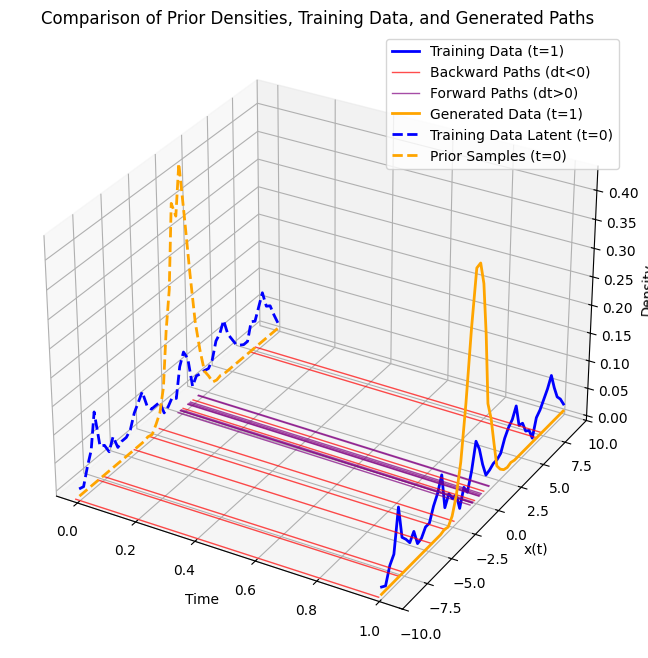

Epoch 0, Log Likelihood: -8.95859 (train), -6.27608 (val), -6.27608 (val rk4), 0.00000 (val-val rk4)
Epoch 1, Log Likelihood: -4.35458 (train), -3.67874 (val), -3.67874 (val rk4), 0.00000 (val-val rk4)
Epoch 2, Log Likelihood: -3.40710 (train), -3.27273 (val), -3.27273 (val rk4), 0.00000 (val-val rk4)
Epoch 3, Log Likelihood: -3.24485 (train), -3.20641 (val), -3.20641 (val rk4), 0.00000 (val-val rk4)
Epoch 4, Log Likelihood: -3.15908 (train), -3.12595 (val), -3.12595 (val rk4), 0.00000 (val-val rk4)
Epoch 5, Log Likelihood: -3.11842 (train), -3.12708 (val), -3.12708 (val rk4), 0.00000 (val-val rk4)
Epoch 6, Log Likelihood: -3.11553 (train), -3.10576 (val), -3.10576 (val rk4), 0.00000 (val-val rk4)
Epoch 7, Log Likelihood: -3.10579 (train), -3.11097 (val), -3.11097 (val rk4), 0.00000 (val-val rk4)
Epoch 8, Log Likelihood: -3.09501 (train), -3.09381 (val), -3.09381 (val rk4), 0.00000 (val-val rk4)
Epoch 9, Log Likelihood: -3.08950 (train), -3.09850 (val), -3.09850 (val rk4), 0.00000 (val

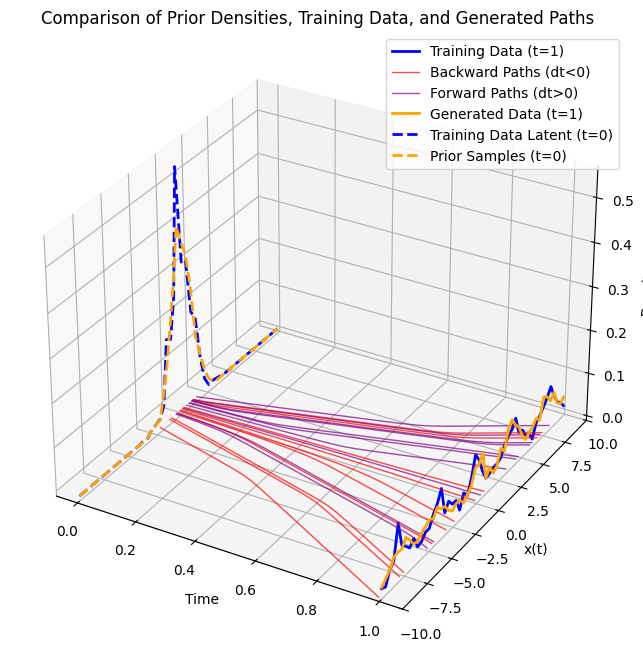

In [10]:
data_loader = torch.utils.data.DataLoader(training_data, batch_size=125, shuffle=True)
set_seed(42)
# Initialize the networks
f_net = DriftNetwork()

# Set the prior (Gaussian or Laplace, as needed) and Likelihood
prior = Prior(gaussian_sample, gaussian_log_pdf)

# time grid
t = torch.linspace(0, 1, steps=100) # ODE discretization

# visualize paths and marginals
forward_path = ForwardPath(mode="ode", f_net=f_net, prior=prior)
backward_path = BackwardPath(mode="ode", f_net=f_net)
visualize_paths_and_marginals(validation_data, t, backward_path, forward_path)

# Train the ODE
trained_f_net = training_loop_ode(
    f_net, prior, data_loader, validation_data, t=t, method="rk4", n_epochs=100, lr=1e-2
)

visualize_paths_and_marginals(validation_data, t, backward_path, forward_path)